# Config

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import expon, gamma, pareto
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [3]:
TOTAL_TIME = 32400
NUM_LEVELS = 5
TICK_SIZE = 0.01
INITIAL_MID_PRICE = 171.005
LEVEL_WEIGHTS = [0.5, 0.25, 0.1, 0.075, 0.075]
size_shape, size_scale = 2.5, 1.5/2.5
g_shape, g_scale = 5, 8

In [76]:
a1, b1, c1 = 64.459, 0.103, 4.932
a2, b2, c2 = 53.086, 0.110, 5.331
a3, b3, c3 = 4.900, 0.122, 0.145
a5, b5, c5 = 4.363, 0.502, 0.122

def l1(x):
    if x < 4:
        return 15 + x*18/4
    if x < 8:
        return 33
    return a1 * np.exp(-b1 * x) + c1
def l2(x):
    if x < 4:
        return 10 + 4*x
    if x < 8:
        return 27
    return a2 * np.exp(-b2 * x) + c2
def l3(x):
    return max(a3 * np.exp(-b3 * x) + c3, 0)
def l4(x):
    if x < 2.5:
        return (-1.3*x + 3.5)*10
    else:
        return (max(-0.1*x + 0.5, 0))*10
def l5(x):
    return (max(a5 * np.exp(-b5 * x) + c5, 0))*10

# Utilities

In [5]:
def initialize_lob():
    bid_queues = gamma.rvs(a=g_shape, scale=g_scale, size=NUM_LEVELS, random_state=42).tolist()
    ask_queues = gamma.rvs(a=g_shape, scale=g_scale, size=NUM_LEVELS, random_state=41).tolist()
    return bid_queues, ask_queues

In [6]:
def compute_stats(df):
    stats = {}
    for level in range(NUM_LEVELS):
        level_df = df[df['level'] == level]
        stats[level] = {
            '#L': len(level_df[level_df['type'] == 'L']),
            '#C': len(level_df[level_df['type'] == 'C']),
            '#M': len(level_df[level_df['type'] == 'M']),
            'AES': level_df['size'].mean(),
            'AIT': np.diff(level_df['time']).mean() * 1000 if len(level_df) > 1 else np.nan
        }
    
    unique_times = np.unique(df['time'])
    price_changes = np.diff(df['mid_price'].reindex(unique_times, method='ffill'))
    annualized_volatility = price_changes.std() * np.sqrt(252 * 32400)
    
    stats_df = pd.DataFrame(stats).T
    stats_df.loc['Volatility'] = np.nan
    stats_df.at['Volatility', 'Volatility'] = annualized_volatility
    
    return stats_df

In [6]:
class OrderBookIntensity:
    def __init__(self, bid_queues, ask_queues):
        self.intensity = {}
        self.global_lambda=0
        self.initialize(bid_queues, ask_queues)
        
    def _scale(self, base, level):
        return base * (LEVEL_WEIGHTS[level] / LEVEL_WEIGHTS[0])

    def _compute_intensity(self, side, level_index, queue_size):
        limit_lambda = l1(queue_size)
        cancel_lambda = l2(queue_size)

        if level_index == 0:
            market_lambda = l3(queue_size)
        else:
            market_lambda = 0

        return [
            self._scale(limit_lambda, level_index),
            self._scale(cancel_lambda, level_index),
            self._scale(market_lambda, level_index)
        ]
    
    def initialize(self, bid_queues, ask_queues):
        for level, queue_size in enumerate(bid_queues):
            self.update("bid", level, queue_size)

        for level, queue_size in enumerate(ask_queues):
            self.update("ask", level, queue_size)
        
    def update(self, side, level, queue_size):
        self.intensity[f"{side}{level}"] = self._compute_intensity(side, level, queue_size)
        self._update_global_lambda()
    
    def _update_global_lambda(self):
        self.global_lambda = sum(sum(lambdas) for lambdas in self.intensity.values())   
        
    def sample_next_event(self):
        side = random.choice(["bid", "ask"])
        level = np.random.choice(range(5), p=LEVEL_WEIGHTS)

        key = f"{side}{level}"
        lambdas = self.intensity[key]
        event_type = random.choices(
            ["L", "C", "M"],
            weights=lambdas,
            k=1
        )[0]
        
        size = pareto.rvs(size_shape, scale=size_scale)
        dt = expon.rvs(scale=1/20)
        return side, level, event_type, size, dt

# QR

In [183]:
def simulate_qr():
    bid_queues, ask_queues = initialize_lob()
    OBI = OrderBookIntensity(bid_queues, ask_queues)
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating SAQR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:
        side, level, event_type, size, dt = OBI.sample_next_event()
        queues = bid_queues if side == 'bid' else ask_queues
        q_before = queues[level]
        
        t += dt
        progress_bar.update(dt)
        if t > TOTAL_TIME:
            break
            
        if event_type == 'L':
            queues[level] += size
            OBI.update(side, level, queues[level])
            
        elif event_type == 'C':
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
            OBI.update(side, level, queues[level])
            
            if queues[0] == 0:
                opp_queues = ask_queues if side == 'bid' else bid_queues
                if np.random.random() < 0.7:
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    opp_queues.pop()
                    
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                    
                    for lvl in range(5):
                        OBI.update("bid", lvl, bid_queues[lvl])
                        OBI.update("ask", lvl, ask_queues[lvl])
                else:
                    queues[0] = gamma.rvs(a=2, scale=10)
                    OBI.update(side, 0, queues[0])
        
            
        elif event_type == 'M':
            rem_size = size
            opp_queues = ask_queues if side == 'bid' else bid_queues
            while rem_size > 0:
                available = queues[0]
                if rem_size < available:
                        queues[0] -= rem_size
                        rem_size = 0
                else:
                    rem_size -= available
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    opp_queues.pop()
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                            
            for lvl in range(5):
                OBI.update("bid", lvl, bid_queues[lvl])
                OBI.update("ask", lvl, ask_queues[lvl])
    
        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
    progress_bar.close()
    print('Simulation completed.')
    return pd.DataFrame(events)

Simulating SAQR:  99%|█████████▉| 5365.7447725387565/5400 [00:10<00:00, 481.89time/s]C:\Users\Nvve\anaconda3\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulating SAQR: 100%|██████████| 5400.019795644922/5400 [00:11<00:00, 488.57time/s] 


Simulation completed.


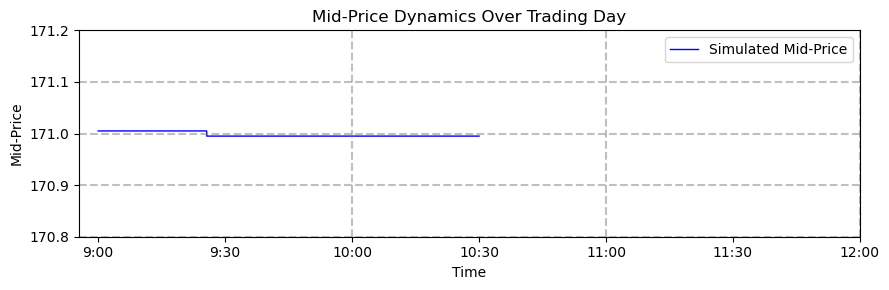

In [184]:
stylized_data = simulate_qr()
times = stylized_data['time'].unique()
mid_prices = stylized_data['mid_price'].reindex(times, method='ffill')
hours = (times / 3600)
plt.figure(figsize=(9, 3))
plt.plot(hours, mid_prices, label='Simulated Mid-Price', color='blue', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend()
time_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
time_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
plt.xticks(time_values, time_labels)
plt.yticks([170.8,170.9,171.0,171.1,171.2])
plt.axhline(y=171.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.2, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.9, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.8, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=3, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('results/images/simul_mid_price_dynamics.png')
plt.show()

In [185]:
df_grouped = stylized_data.groupby(['side', 'level'])['queue_before'].mean()
df_grouped

side  level
ask   0        39.376450
      1        37.421429
      2        37.485472
      3        39.050262
      4        51.428172
bid   0        41.534410
      1        59.575865
      2        79.775437
      3        60.485767
      4        59.328586
Name: queue_before, dtype: float64

In [186]:
stylized_data['type'].value_counts(normalize=True) # normalize=True

type
L    0.498365
C    0.492956
M    0.008679
Name: proportion, dtype: float64

C:\Users\Nvve\AppData\Local\Temp\ipykernel_4724\2020222306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


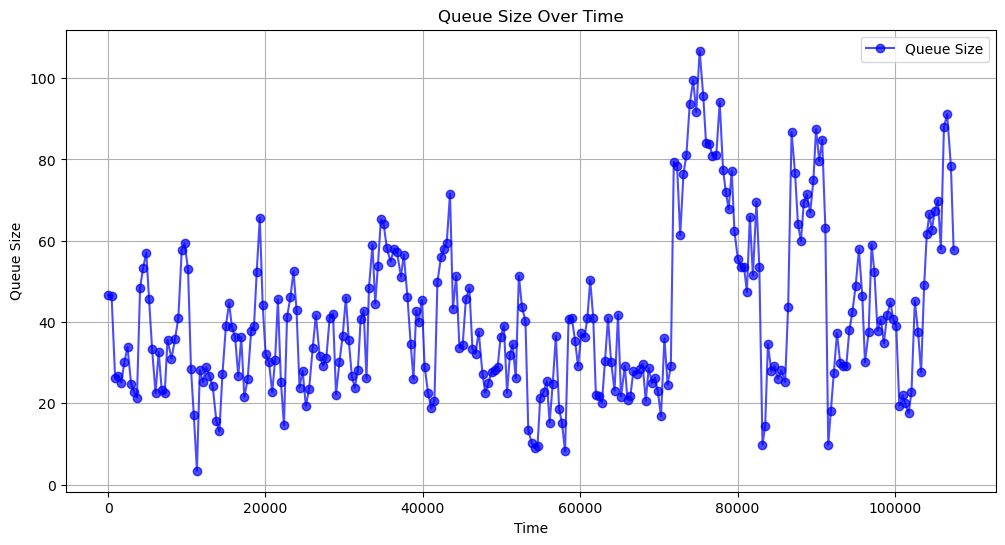

In [187]:
df_filtered = stylized_data[(stylized_data['side'] == 'bid') & (stylized_data['level'] == 0)]
df = df_filtered.iloc[::100]
import matplotlib.pyplot as plt

# 确保 'time' 是 datetime 类型
df['time'] = pd.to_datetime(df['time'])

# 按时间排序（避免乱序）
#df = df.sort_values(by='time')

# 绘制曲线图
plt.figure(figsize=(12, 6))
plt.plot(df['queue_before'], marker='o', linestyle='-', color='b', alpha=0.7, label='Queue Size')

# 添加标题和标签
plt.xlabel('Time')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.legend()
#plt.xticks(rotation=45)  # 旋转 x 轴刻度
plt.grid()

# 显示图像
plt.show()

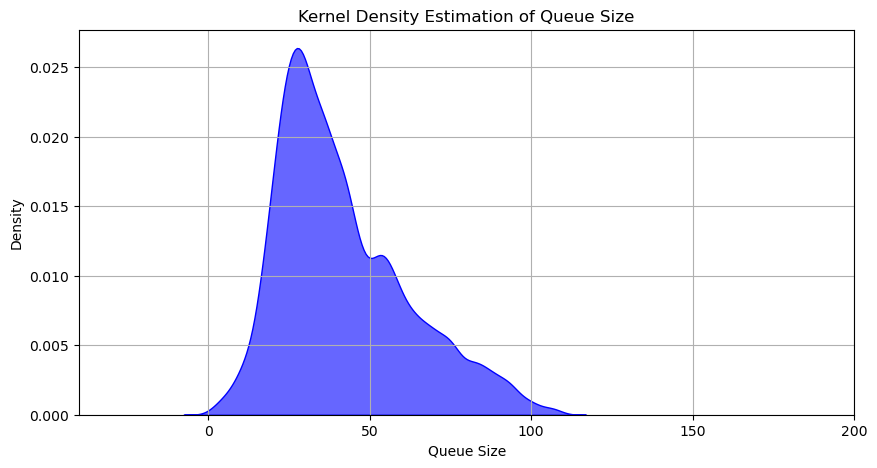

In [188]:
df = df_filtered
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(df['queue_before'], fill=True, color='blue', alpha=0.6)

# 限制 x 轴范围
plt.xlim(-40, 200)  # 让 x 轴最大值为 200

plt.xlabel('Queue Size')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Queue Size')
plt.grid()
plt.show()

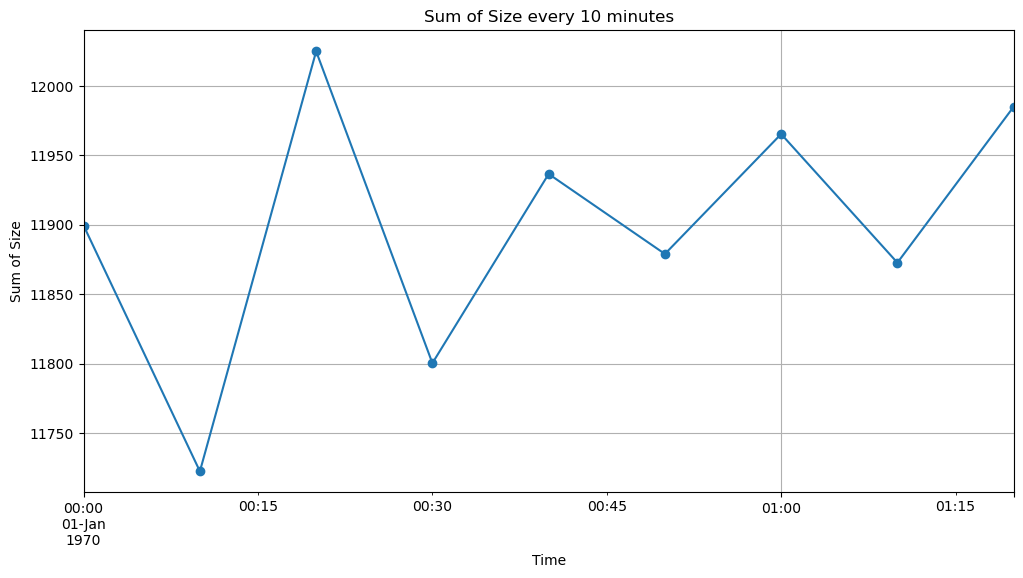

In [189]:
df =  stylized_data.copy()
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.set_index('time')

# === 每10分钟聚合一次，求size的sum ===
sum_per_10min = df['size'].resample('10min').sum()

# === 画图 ===
plt.figure(figsize=(12, 6))
sum_per_10min.plot(marker='o', linestyle='-')
plt.title('Sum of Size every 10 minutes')
plt.xlabel('Time')
plt.ylabel('Sum of Size')
plt.grid(True)
plt.show()

Stylized Facts Simulated Data Stats (Level 1-5):
                 #L       #C     #M       AES         AIT  Volatility
0           26774.0  26137.0  934.0  0.990399  100.286180         NaN
1           13509.0  13525.0    0.0  0.989953  199.735002         NaN
2            5272.0   5397.0    0.0  1.016192  506.101838         NaN
3            4033.0   3962.0    0.0  0.999927  675.398075         NaN
4            4043.0   4028.0    0.0  1.011010  669.029691         NaN
Volatility      NaN      NaN    NaN       NaN         NaN    0.087104

Rolling Volatility Over Time:
      time  volatility
0      300         0.0
1      301         0.0
2      302         0.0
3      303         0.0
4      304         0.0
...    ...         ...
4797  5097         0.0
4798  5098         0.0
4799  5099         0.0
4800  5100         0.0
4801  5101         0.0

[4802 rows x 2 columns]


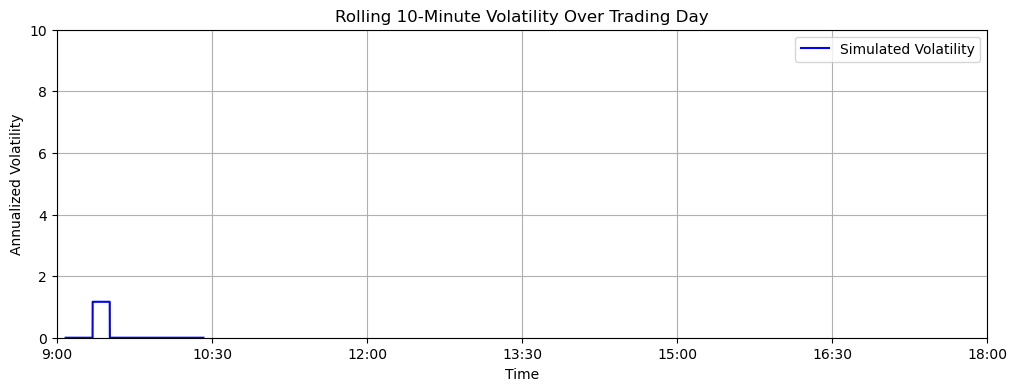

In [190]:
resampled_times = np.arange(0, TOTAL_TIME + 1, 1)
resampled_prices = stylized_data['mid_price'].reindex(resampled_times, method='ffill')

rolling_volatility = []
window_size = 600
times = resampled_times

for i in range(0, len(times) - window_size + 1): 
    window_times = times[i:i + window_size]
    window_prices = resampled_prices[window_times]
    window_changes = np.diff(window_prices)
    if len(window_changes) > 0:
        vol = window_changes.std() * np.sqrt(252 * 32400)
        rolling_volatility.append((times[i + window_size // 2], vol))
rolling_vol = pd.DataFrame(rolling_volatility, columns=['time', 'volatility'])

stylized_stats = compute_stats(stylized_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)
print("\nRolling Volatility Over Time:")
print(rolling_vol)

plt.figure(figsize=(12, 4))
plt.plot(rolling_vol['time'] / 3600, rolling_vol['volatility'], label='Simulated Volatility',color = 'blue')
plt.xlabel('Time')
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.ylim(0, 10)
plt.xticks(time_values, time_labels)
plt.ylabel('Annualized Volatility')
plt.title('Rolling 10-Minute Volatility Over Trading Day')
plt.legend()
plt.grid(True)
#plt.savefig('results/images/simul_volatility.png')
plt.show()

# SAQR

In [7]:
def simulate_saqr():
    bid_queues, ask_queues = initialize_lob()
    OBI = OrderBookIntensity(bid_queues, ask_queues)
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating SAQR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:
        side, level, event_type, size, dt = OBI.sample_next_event()
        queues = bid_queues if side == 'bid' else ask_queues
        q_before = queues[level]
        
        t += dt
        progress_bar.update(dt)
        if t > TOTAL_TIME:
            break
            
        if event_type == 'L':
            queues[level] += size
            OBI.update(side, level, queues[level])
        elif event_type == 'C':
            if np.random.random() < np.exp(-3):
                size = max(30, size)
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
            OBI.update(side, level, queues[level])
            
            if queues[0] == 0:
                opp_queues = ask_queues if side == 'bid' else bid_queues
                if np.random.random() < 0.7:
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    opp_queues.pop()
                    
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                    
                    for lvl in range(5):
                        OBI.update("bid", lvl, bid_queues[lvl])
                        OBI.update("ask", lvl, ask_queues[lvl])
                else:
                    #queues[0] = 0
                    queues[0] = gamma.rvs(a=2, scale=10)
                    #queues[0] = pareto.rvs(size_shape, scale=size_scale)
                    OBI.update(side, 0, queues[0])
        
            
        elif event_type == 'M':
            if np.random.random() < np.exp(-2):
                size = max(30, size)
            rem_size = size
            opp_queues = ask_queues if side == 'bid' else bid_queues
            while rem_size > 0:
                available = queues[0]
                if rem_size < available:
                        queues[0] -= rem_size
                        rem_size = 0
                else:
                    rem_size -= available
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    opp_queues.pop()
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                            
            for lvl in range(5):
                OBI.update("bid", lvl, bid_queues[lvl])
                OBI.update("ask", lvl, ask_queues[lvl])
    
        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
    progress_bar.close()
    print('Simulation completed.')
    return pd.DataFrame(events)

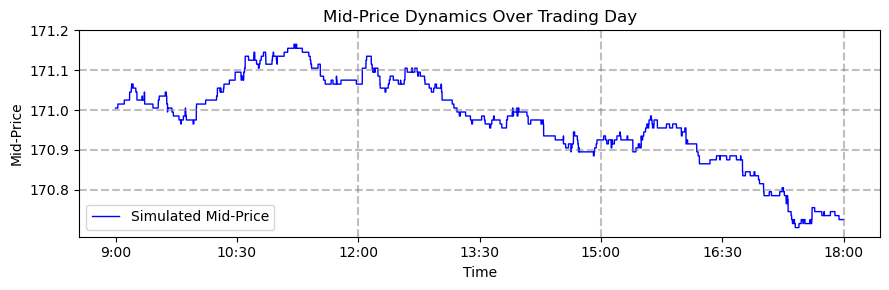

In [9]:
stylized_data = simulate_saqr()
times = stylized_data['time'].unique()
mid_prices = stylized_data['mid_price'].reindex(times, method='ffill')
hours = (times / 3600)
plt.figure(figsize=(9, 3))
plt.plot(hours, mid_prices, label='Simulated Mid-Price', color='blue', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend()
#time_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
#time_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.xticks(time_values, time_labels)
plt.yticks([170.8,170.9,171.0,171.1,171.2])
plt.axhline(y=171.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.2, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.9, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.8, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=3, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=6, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=9, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('results/images/simul_mid_price_dynamics.png')
plt.show()

In [10]:
df_grouped = stylized_data.groupby(['side', 'level'])['queue_before'].mean()
df_grouped

side  level
ask   0        22.072276
      1        18.666745
      2        21.372877
      3        25.015064
      4        29.457784
bid   0        21.670108
      1        18.999938
      2        21.489870
      3        25.331392
      4        30.760802
Name: queue_before, dtype: float64

In [11]:
stylized_data['type'].value_counts(normalize=True) # normalize=True

type
L    0.527926
C    0.458639
M    0.013435
Name: proportion, dtype: float64

C:\Users\Nvve\AppData\Local\Temp\ipykernel_8252\4114332496.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


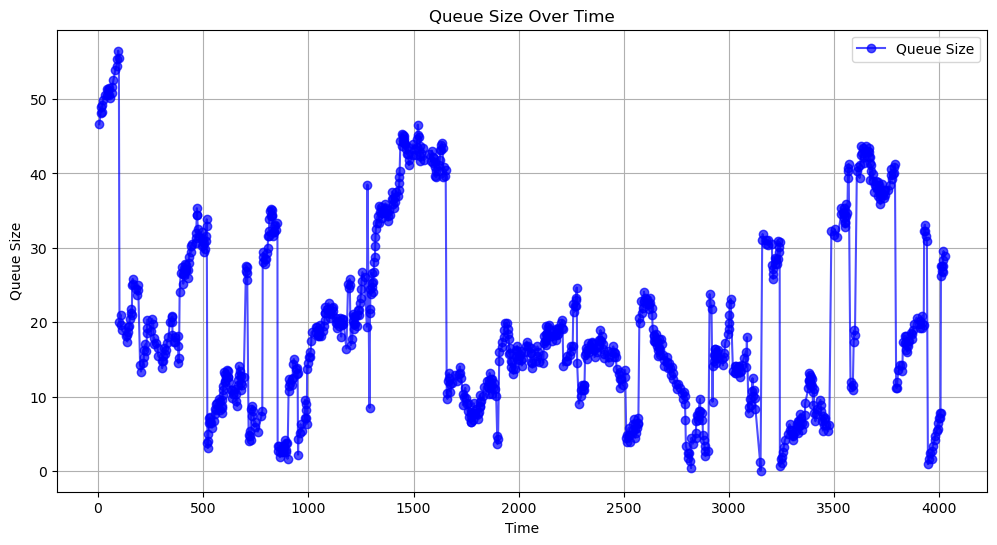

In [12]:
df_filtered = stylized_data[(stylized_data['side'] == 'bid') & (stylized_data['level'] == 0)]
df = df_filtered.iloc[:1000]
import matplotlib.pyplot as plt

# 确保 'time' 是 datetime 类型
df['time'] = pd.to_datetime(df['time'])

# 按时间排序（避免乱序）
#df = df.sort_values(by='time')

# 绘制曲线图
plt.figure(figsize=(12, 6))
plt.plot(df['queue_before'], marker='o', linestyle='-', color='b', alpha=0.7, label='Queue Size')

# 添加标题和标签
plt.xlabel('Time')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.legend()
#plt.xticks(rotation=45)  # 旋转 x 轴刻度
plt.grid()

# 显示图像
plt.show()

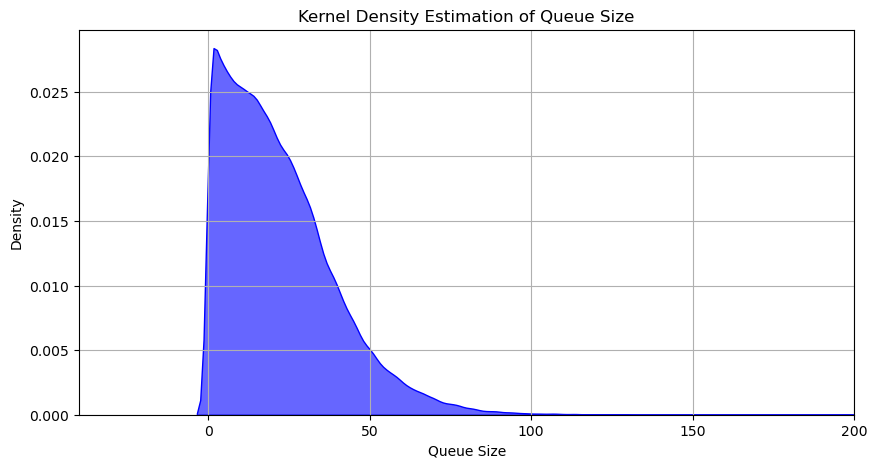

In [13]:
#df = df_filtered
df = stylized_data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(df['queue_before'], fill=True, color='blue', alpha=0.6)

# 限制 x 轴范围
plt.xlim(-40, 200)  # 让 x 轴最大值为 200

plt.xlabel('Queue Size')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Queue Size')
plt.grid()
plt.show()

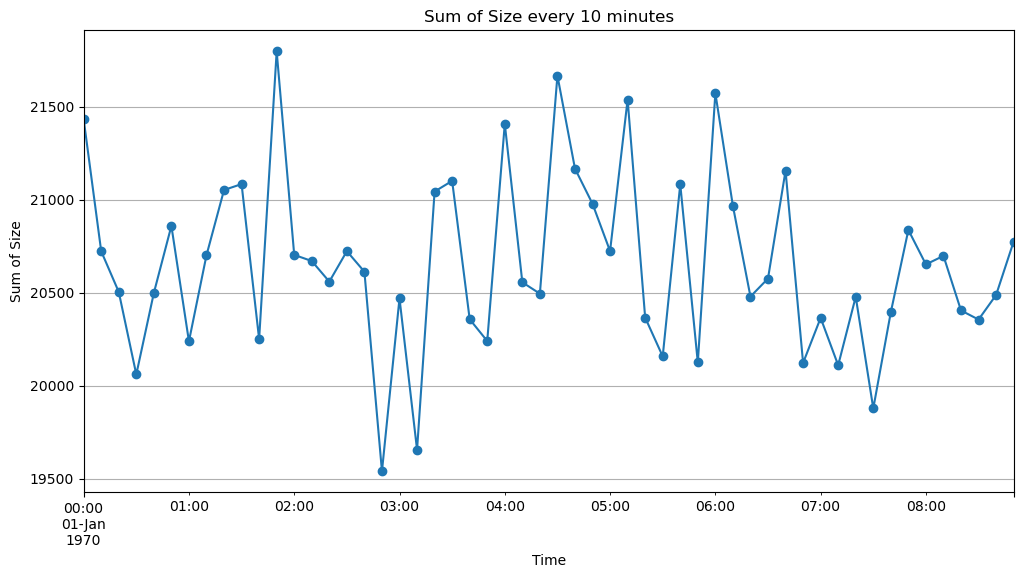

In [14]:
df =  stylized_data.copy()
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.set_index('time')

# === 每10分钟聚合一次，求size的sum ===
sum_per_10min = df['size'].resample('10min').sum()

# === 画图 ===
plt.figure(figsize=(12, 6))
sum_per_10min.plot(marker='o', linestyle='-')
plt.title('Sum of Size every 10 minutes')
plt.xlabel('Time')
plt.ylabel('Sum of Size')
plt.grid(True)
plt.show()

Stylized Facts Simulated Data Stats (Level 1-5):
                  #L        #C      #M       AES         AIT  Volatility
0           168352.0  146557.0  8713.0  1.769551  100.117020         NaN
1            87799.0   74524.0     0.0  1.654599  199.602482         NaN
2            34722.0   30126.0     0.0  1.662445  499.634563         NaN
3            25979.0   23024.0     0.0  1.691099  661.186793         NaN
4            25524.0   23210.0     0.0  1.714422  664.818459         NaN
Volatility       NaN       NaN     NaN       NaN         NaN    0.759347

Rolling Volatility Over Time:
        time  volatility
0        300    1.648345
1        301    1.648345
2        302    1.648345
3        303    1.648345
4        304    1.648345
...      ...         ...
31797  32097    2.021618
31798  32098    2.021618
31799  32099    2.021618
31800  32100    2.021618
31801  32101    2.021618

[31802 rows x 2 columns]


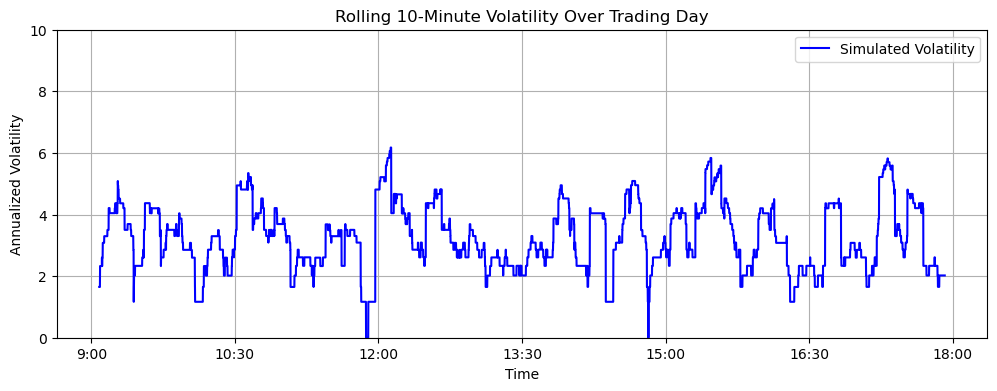

In [15]:
resampled_times = np.arange(0, TOTAL_TIME + 1, 1)
resampled_prices = stylized_data['mid_price'].reindex(resampled_times, method='ffill')

rolling_volatility = []
window_size = 600
times = resampled_times

for i in range(0, len(times) - window_size + 1): 
    window_times = times[i:i + window_size]
    window_prices = resampled_prices[window_times]
    window_changes = np.diff(window_prices)
    if len(window_changes) > 0:
        vol = window_changes.std() * np.sqrt(252 * 32400)
        rolling_volatility.append((times[i + window_size // 2], vol))
rolling_vol = pd.DataFrame(rolling_volatility, columns=['time', 'volatility'])

stylized_stats = compute_stats(stylized_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)
print("\nRolling Volatility Over Time:")
print(rolling_vol)

plt.figure(figsize=(12, 4))
plt.plot(rolling_vol['time'] / 3600, rolling_vol['volatility'], label='Simulated Volatility',color = 'blue')
plt.xlabel('Time')
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.ylim(0, 10)
plt.xticks(time_values, time_labels)
plt.ylabel('Annualized Volatility')
plt.title('Rolling 10-Minute Volatility Over Trading Day')
plt.legend()
plt.grid(True)
#plt.savefig('results/images/simul_volatility.png')
plt.show()

# FTQR

In [77]:
class OrderBookIntensity:
    def __init__(self, bid_queues, ask_queues):
        self.intensity = {}
        self.global_lambda = 0
        self.initialize(bid_queues, ask_queues)

    def _scale(self, base, level):
        return base * (LEVEL_WEIGHTS[level] / LEVEL_WEIGHTS[0])

    def _compute_intensity(self, side, level_index, queue_size):
        limit_lambda = l1(queue_size)
        cancel_lambda = l2(queue_size)
        cancel_all_lambda = l4(queue_size)
        
        if level_index == 0:
            market_lambda = l3(queue_size)
            market_all_lambda = l5(queue_size)
        else:
            market_lambda = 0
            market_all_lambda = 0

        return [
            self._scale(limit_lambda, level_index),      # L
            self._scale(cancel_lambda, level_index),     # C
            self._scale(market_lambda, level_index),     # M
            self._scale(cancel_all_lambda, level_index), # CA
            self._scale(market_all_lambda, level_index)  # MA
        ]

    def initialize(self, bid_queues, ask_queues):
        for level, queue_size in enumerate(bid_queues):
            self.update("bid", level, queue_size)

        for level, queue_size in enumerate(ask_queues):
            self.update("ask", level, queue_size)

    def update(self, side, level, queue_size):
        self.intensity[f"{side}{level}"] = self._compute_intensity(side, level, queue_size)
        self._update_global_lambda()

    def _update_global_lambda(self):
        self.global_lambda = sum(sum(lambdas) for lambdas in self.intensity.values())

    def sample_next_event(self):
        side = random.choice(["bid", "ask"])
        level = np.random.choice(range(5), p=LEVEL_WEIGHTS)

        key = f"{side}{level}"
        lambdas = self.intensity[key]
        event_type = random.choices(
            ["L", "C", "M", "CA", "MA"],
            weights=lambdas,
            k=1
        )[0]
        
        size = pareto.rvs(size_shape, scale=size_scale)
        dt = expon.rvs(scale=1/50)
        return side, level, event_type, size, dt

In [78]:
def simulate_ftqr():
    bid_queues, ask_queues = initialize_lob()
    OBI = OrderBookIntensity(bid_queues, ask_queues)
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating FTQR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:
        side, level, event_type, size, dt = OBI.sample_next_event()
        queues = bid_queues if side == 'bid' else ask_queues
        q_before = queues[level]
        
        t += dt
        progress_bar.update(dt)
        if t > TOTAL_TIME:
            break
            
        if event_type == 'L':
            queues[level] += size
            OBI.update(side, level, queues[level])
        elif event_type == 'C' or event_type == 'CA':
            if event_type == 'CA':
                size = q_before
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
            OBI.update(side, level, queues[level])
            
            if queues[0] == 0:
                opp_queues = ask_queues if side == 'bid' else bid_queues
                if np.random.random() < 0.7:
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    #opp_queues.insert(0,0)
                    opp_queues.pop()
                    
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                    
                    for lvl in range(5):
                        OBI.update("bid", lvl, bid_queues[lvl])
                        OBI.update("ask", lvl, ask_queues[lvl])
                else:
                    #queues[0] = 0
                    queues[0] = gamma.rvs(a=2, scale=10)
                    #queues[0] = pareto.rvs(size_shape, scale=size_scale)
                    OBI.update(side, 0, queues[0])
        
            
        elif event_type == 'M' or event_type == 'MA':
            if event_type == 'MA':
                size = q_before
            rem_size = size
            opp_queues = ask_queues if side == 'bid' else bid_queues
            while rem_size > 0:
                available = queues[0]
                if rem_size < available:
                        queues[0] -= rem_size
                        rem_size = 0
                else:
                    rem_size -= available
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    #opp_queues.insert(0,0)
                    opp_queues.pop()
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                            
            for lvl in range(5):
                OBI.update("bid", lvl, bid_queues[lvl])
                OBI.update("ask", lvl, ask_queues[lvl])
    
        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
    progress_bar.close()
    print('Simulation completed.')
    return pd.DataFrame(events)

Simulating FTQR: 100%|█████████▉| 5387.154519461895/5400 [00:30<00:00, 186.03time/s] C:\Users\Nvve\anaconda3\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulating FTQR: 100%|██████████| 5400.0043321520825/5400 [00:30<00:00, 177.34time/s]


Simulation completed.


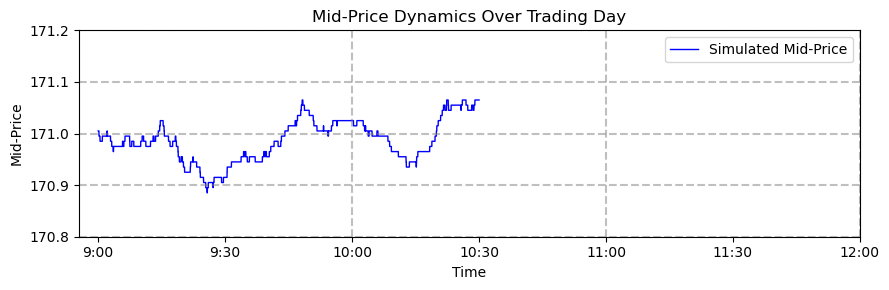

In [79]:
stylized_data = simulate_ftqr()
times = stylized_data['time'].unique()
mid_prices = stylized_data['mid_price'].reindex(times, method='ffill')
hours = (times / 3600)
plt.figure(figsize=(9, 3))
plt.plot(hours, mid_prices, label='Simulated Mid-Price', color='blue', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend()
time_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
time_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
plt.xticks(time_values, time_labels)
plt.yticks([170.8,170.9,171.0,171.1,171.2])
plt.axhline(y=171.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.2, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.9, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.8, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=3, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('results/images/simul_mid_price_dynamics.png')
plt.show()

In [80]:
df_grouped = stylized_data.groupby(['side', 'level'])['queue_before'].mean()
df_grouped

side  level
ask   0        22.654393
      1        26.665634
      2        29.652867
      3        33.787790
      4        36.892594
bid   0        22.044538
      1        26.397940
      2        29.605602
      3        32.742137
      4        36.807440
Name: queue_before, dtype: float64

In [81]:
stylized_data['type'].value_counts(normalize=True) # normalize=True

type
L     0.504727
C     0.450210
MA    0.028909
M     0.011677
CA    0.004477
Name: proportion, dtype: float64

C:\Users\Nvve\AppData\Local\Temp\ipykernel_21408\2020222306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


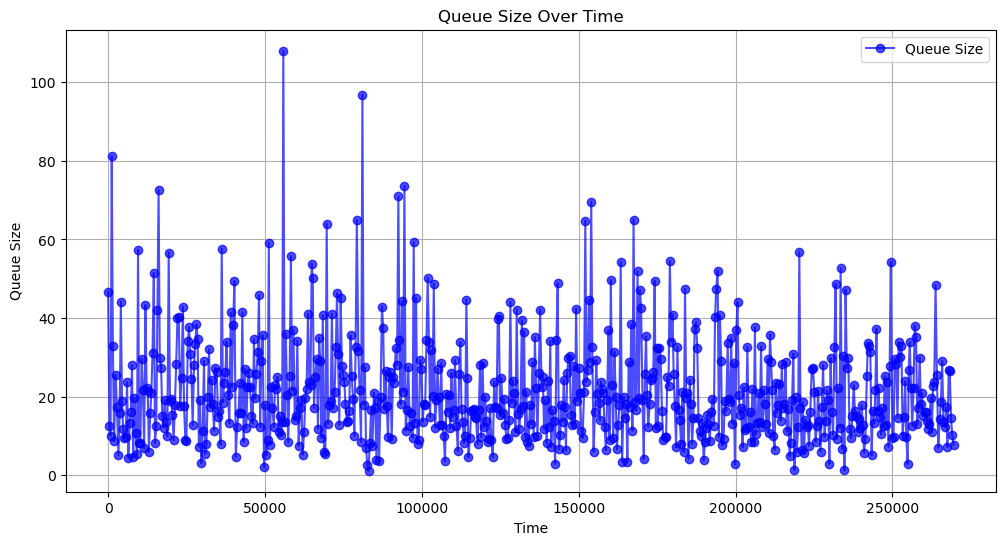

In [82]:
df_filtered = stylized_data[(stylized_data['side'] == 'bid') & (stylized_data['level'] == 0)]
df = df_filtered.iloc[::100]
import matplotlib.pyplot as plt

# 确保 'time' 是 datetime 类型
df['time'] = pd.to_datetime(df['time'])

# 按时间排序（避免乱序）
#df = df.sort_values(by='time')

# 绘制曲线图
plt.figure(figsize=(12, 6))
plt.plot(df['queue_before'], marker='o', linestyle='-', color='b', alpha=0.7, label='Queue Size')

# 添加标题和标签
plt.xlabel('Time')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.legend()
#plt.xticks(rotation=45)  # 旋转 x 轴刻度
plt.grid()

# 显示图像
plt.show()

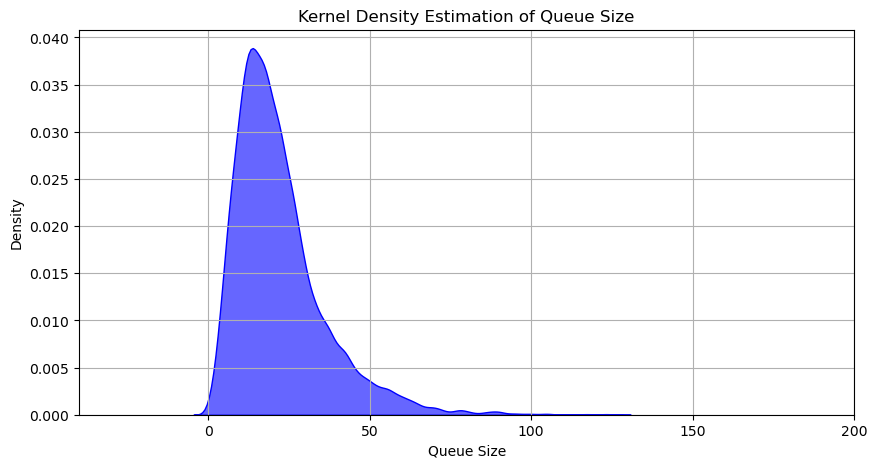

In [83]:
df = df_filtered
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(df['queue_before'], fill=True, color='blue', alpha=0.6)

# 限制 x 轴范围
plt.xlim(-40, 200)  # 让 x 轴最大值为 200

plt.xlabel('Queue Size')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Queue Size')
plt.grid()
plt.show()

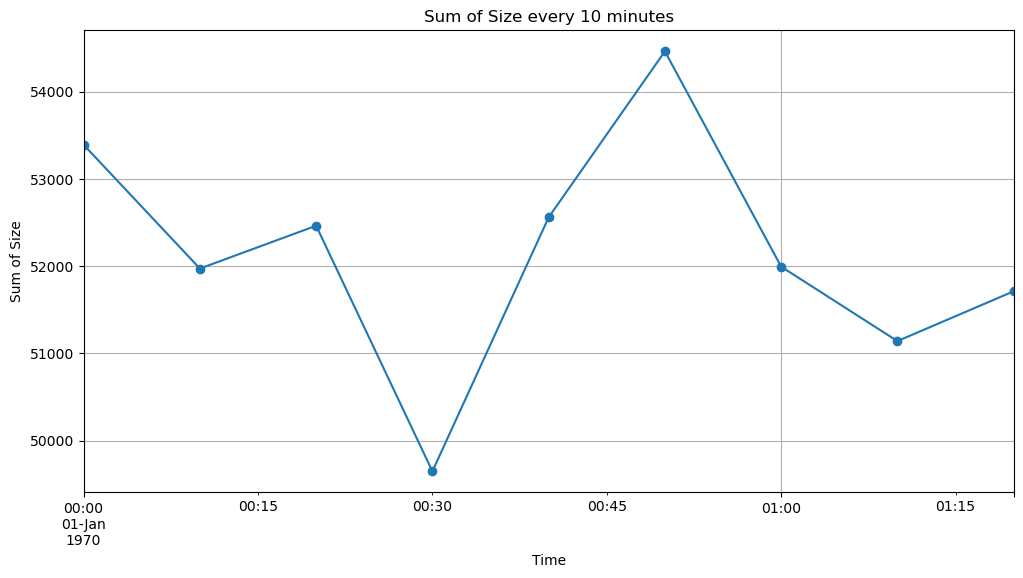

In [84]:
df =  stylized_data.copy()
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.set_index('time')

# === 每10分钟聚合一次，求size的sum ===
sum_per_10min = df['size'].resample('10min').sum()

# === 画图 ===
plt.figure(figsize=(12, 6))
sum_per_10min.plot(marker='o', linestyle='-')
plt.title('Sum of Size every 10 minutes')
plt.xlabel('Time')
plt.ylabel('Sum of Size')
plt.grid(True)
plt.show()

Stylized Facts Simulated Data Stats (Level 1-5):
                 #L       #C      #M       AES         AIT  Volatility
0           66154.0  57759.0  3151.0  2.479821   39.963831         NaN
1           35074.0  31461.0     0.0  0.997345   80.486255         NaN
2           14117.0  12652.0     0.0  0.992987  200.157626         NaN
3           10557.0   9791.0     0.0  0.992163  263.645184         NaN
4           10295.0   9823.0     0.0  1.004551  267.675048         NaN
Volatility      NaN      NaN     NaN       NaN         NaN    0.678172

Rolling Volatility Over Time:
      time  volatility
0      300    4.811626
1      301    4.811626
2      302    4.811626
3      303    4.952392
4      304    4.952392
...    ...         ...
4797  5097    5.213398
4798  5098    5.213398
4799  5099    5.213398
4800  5100    5.083451
4801  5101    5.083451

[4802 rows x 2 columns]


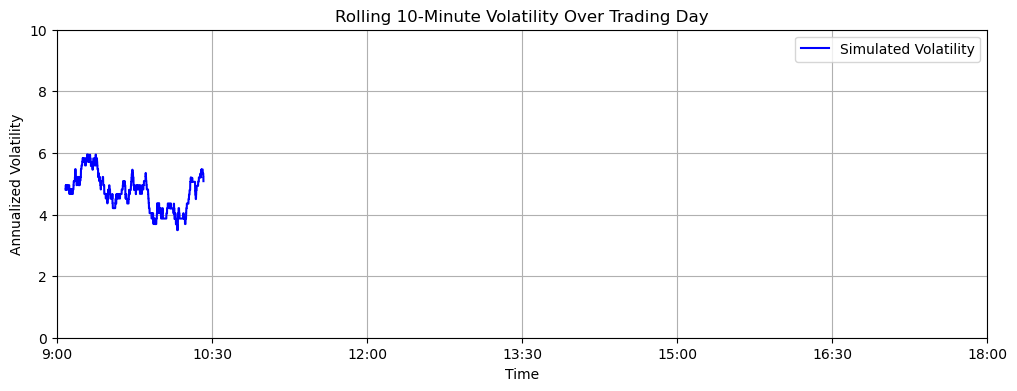

In [85]:
resampled_times = np.arange(0, TOTAL_TIME + 1, 1)
resampled_prices = stylized_data['mid_price'].reindex(resampled_times, method='ffill')

rolling_volatility = []
window_size = 600
times = resampled_times

for i in range(0, len(times) - window_size + 1): 
    window_times = times[i:i + window_size]
    window_prices = resampled_prices[window_times]
    window_changes = np.diff(window_prices)
    if len(window_changes) > 0:
        vol = window_changes.std() * np.sqrt(252 * 32400)
        rolling_volatility.append((times[i + window_size // 2], vol))
rolling_vol = pd.DataFrame(rolling_volatility, columns=['time', 'volatility'])

stylized_stats = compute_stats(stylized_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)
print("\nRolling Volatility Over Time:")
print(rolling_vol)

plt.figure(figsize=(12, 4))
plt.plot(rolling_vol['time'] / 3600, rolling_vol['volatility'], label='Simulated Volatility',color = 'blue')
plt.xlabel('Time')
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.ylim(0, 10)
plt.xticks(time_values, time_labels)
plt.ylabel('Annualized Volatility')
plt.title('Rolling 10-Minute Volatility Over Trading Day')
plt.legend()
plt.grid(True)
#plt.savefig('results/images/simul_volatility.png')
plt.show()

# DP

In [173]:
class OrderBookIntensity:
    def __init__(self, bid_queues, ask_queues):
        self.intensity = {}
        self.global_lambda=0
        self.events = []
        self.weights = []
        self._init_event_pool()
        self.initialize(bid_queues, ask_queues)
        
    def _scale(self, base, level):
        return base * (LEVEL_WEIGHTS[level] / LEVEL_WEIGHTS[0])

    def _compute_intensity(self, side, level_index, queue_size):
        limit_lambda = l1(queue_size)
        cancel_lambda = l2(queue_size)

        if level_index == 0:
            market_lambda = l3(queue_size)
        else:
            market_lambda = 0

        return [
            self._scale(limit_lambda, level_index),
            self._scale(cancel_lambda, level_index),
            self._scale(market_lambda, level_index)
        ]
    
    def initialize(self, bid_queues, ask_queues):
        for level, queue_size in enumerate(bid_queues):
            self.update("bid", level, queue_size)

        for level, queue_size in enumerate(ask_queues):
            self.update("ask", level, queue_size)
        
    def update(self, side, level, queue_size):
        self.intensity[f"{side}{level}"] = self._compute_intensity(side, level, queue_size)
        self._update_global_lambda()
        self._update_event_weights(side, level)
    
    def _update_global_lambda(self):
        self.global_lambda = sum(sum(lambdas) for lambdas in self.intensity.values())
    
    def _event_index(self, side, level):
        side_offset = 0 if side == "bid" else 5*3
        level_offset = level * 3
        return side_offset + level_offset
    
    def _init_event_pool(self):
        for side in ["bid", "ask"]:
            for level in range(5):
                key = f"{side}{level}"
                for event_type in ["L", "C", "M"]:
                    self.events.append((side, level, event_type))

        self.weights = [0] * len(self.events)
    
    def _update_event_weights(self, side, level):
        lambdas = self.intensity[f"{side}{level}"]  
        base_index = self._event_index(side, level)

        self.weights[base_index] = lambdas[0] 
        self.weights[base_index + 1] = lambdas[1]
        self.weights[base_index + 2] = lambdas[2]
        
    def sample_next_event(self):
        event, = random.choices(self.events, weights=self.weights, k=1)
        side, level, event_type = event
        size = pareto.rvs(size_shape, scale=size_scale)
        #size = 1
        dt = expon.rvs(scale=1/self.global_lambda)
        return side, level, event_type, size, dt

In [55]:
class OrderBookIntensity:
    def __init__(self, bid_queues, ask_queues):
        self.intensity = {}
        self.global_lambda = 0
        self.events = []
        self.weights = []
        self._init_event_pool()
        self.initialize(bid_queues, ask_queues)

    def _scale(self, base, level):
        return base * (LEVEL_WEIGHTS[level] / LEVEL_WEIGHTS[0])

    def _compute_intensity(self, side, level_index, queue_size):
        limit_lambda = l1(queue_size)
        cancel_lambda = l2(queue_size)
        cancel_all_lambda = l4(queue_size)
        
        if level_index == 0:
            market_lambda = l3(queue_size)
            market_all_lambda = l5(queue_size)
        else:
            market_lambda = 0
            market_all_lambda = 0

        return [
            self._scale(limit_lambda, level_index),      # L
            self._scale(cancel_lambda, level_index),     # C
            self._scale(market_lambda, level_index),     # M
            self._scale(cancel_all_lambda, level_index), # CA
            self._scale(market_all_lambda, level_index)  # MA
        ]

    def initialize(self, bid_queues, ask_queues):
        for level, queue_size in enumerate(bid_queues):
            self.update("bid", level, queue_size)

        for level, queue_size in enumerate(ask_queues):
            self.update("ask", level, queue_size)

    def update(self, side, level, queue_size):
        self.intensity[f"{side}{level}"] = self._compute_intensity(side, level, queue_size)
        self._update_global_lambda()
        self._update_event_weights(side, level)

    def _update_global_lambda(self):
        self.global_lambda = sum(sum(lambdas) for lambdas in self.intensity.values())

    def _event_index(self, side, level):
        side_offset = 0 if side == "bid" else 5 * 5  
        level_offset = level * 5  
        return side_offset + level_offset

    def _init_event_pool(self):
        event_types = ["L", "C", "M", "CA", "MA"]

        for side in ["bid", "ask"]:
            for level in range(5):
                for event_type in event_types:
                    self.events.append((side, level, event_type))

        self.weights = [0] * len(self.events)

    def _update_event_weights(self, side, level):
        lambdas = self.intensity[f"{side}{level}"]
        base_index = self._event_index(side, level)

        for i in range(5):  # 5个事件
            self.weights[base_index + i] = lambdas[i]

    def sample_next_event(self):
        event, = random.choices(self.events, weights=self.weights, k=1)
        side, level, event_type = event
        size = pareto.rvs(size_shape, scale=size_scale)
        dt = expon.rvs(scale=1 / self.global_lambda)
        return side, level, event_type, size, dt